In [12]:
import numpy as np
from Load_data import load_data

In [13]:
data = load_data("Data/20242025premierleague.csv")
data

Data loaded successfully from Data/20242025premierleague.csv


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,E0,16/08/2024,20:00,Man United,Fulham,1,0,H,0,0,...,1.86,2.07,1.83,2.11,1.88,2.11,1.82,2.05,1.90,2.08
1,E0,17/08/2024,12:30,Ipswich,Liverpool,0,2,A,0,0,...,2.05,1.88,2.04,1.90,2.20,2.00,1.99,1.88,2.04,1.93
2,E0,17/08/2024,15:00,Arsenal,Wolves,2,0,H,1,0,...,2.02,1.91,2.00,1.90,2.05,1.93,1.99,1.87,2.02,1.96
3,E0,17/08/2024,15:00,Everton,Brighton,0,3,A,0,1,...,1.87,2.06,1.86,2.07,1.92,2.10,1.83,2.04,1.88,2.11
4,E0,17/08/2024,15:00,Newcastle,Southampton,1,0,H,1,0,...,1.87,2.06,1.88,2.06,1.89,2.10,1.82,2.05,1.89,2.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,25/05/2025,16:00,Newcastle,Everton,0,1,A,0,0,...,2.00,1.85,2.01,1.90,2.01,1.95,1.95,1.91,1.93,2.05
376,E0,25/05/2025,16:00,Nott'm Forest,Chelsea,0,1,A,0,0,...,1.80,2.05,1.86,2.08,1.86,2.08,1.81,2.05,1.86,2.14
377,E0,25/05/2025,16:00,Southampton,Arsenal,1,2,A,0,1,...,2.03,1.83,2.04,1.87,2.07,1.87,2.03,1.83,2.06,1.89
378,E0,25/05/2025,16:00,Tottenham,Brighton,1,4,A,1,0,...,1.95,1.90,2.00,1.93,2.01,1.93,1.95,1.89,2.06,1.93


In [14]:
# Importerer alle seasons og sæt dem sammen (men skipper 2004/2005)
from pathlib import Path
import pandas as pd

files = sorted(Path("Data").glob("*premierleague.csv"))

dfs = []

for f in files:
    if "20042005" in f.name:
        continue  # skip problematic season

    season = f.stem.replace("premierleague", "")
    tmp = pd.read_csv(
        f,
        engine="python",
        on_bad_lines="skip"
    )
    tmp["season"] = season
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True, sort=False)

df.shape


(8196, 205)

8196 matches

In [15]:
# Liste over de præcise sæsoner vi har med ift. filnavn.
df["season"].unique()

array(['20032004', '20052006', '20062007', '20072008', '20082009',
       '20092010', '20102011', '20112012', '20122013', '20132014',
       '20142015', '20152016', '20162017', '20172018', '20182019',
       '20192020', '20202021', '20212022', '20222023', '20232024',
       '20242025', '20252026'], dtype=object)

In [16]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# ------------------------------------------------------------
# 1) Select raw match features (home / away)
# ------------------------------------------------------------

raw_match_features = [
    "HS", "AS",      # Shots
    "HST", "AST",    # Shots on target
#    "HHW", "AHW",    # Hit woodwork
    "HC", "AC",      # Corners
    "HF", "AF",      # Fouls committed
#    "HFKC", "AFKC",  # Free kicks conceded
#    "HO", "AO",      # Offsides
    "HY", "AY",      # Yellow cards
    "HR", "AR"       # Red cards
]

# Ensure all selected columns exist and are numeric
X_raw = df[raw_match_features].apply(pd.to_numeric, errors="coerce")

# Drop rows with missing match statistics
X_raw = X_raw.dropna()

# ------------------------------------------------------------
# 2) Construct difference-based (balance / dominance) features
# ------------------------------------------------------------

X_diff = pd.DataFrame({
    "shot_diff":      X_raw["HS"]  - X_raw["AS"],
    "sot_diff":       X_raw["HST"] - X_raw["AST"],
#    "woodwork_diff":  X_raw["HHW"] - X_raw["AHW"],
    "corner_diff":    X_raw["HC"]  - X_raw["AC"],
    "foul_diff":      X_raw["HF"]  - X_raw["AF"],
#    "fk_conc_diff":   X_raw["HFKC"] - X_raw["AFKC"],
#    "offside_diff":   X_raw["HO"]  - X_raw["AO"],
    "yellow_diff":    X_raw["HY"]  - X_raw["AY"],
    "red_diff":       X_raw["HR"]  - X_raw["AR"],
}, index=X_raw.index)

# ------------------------------------------------------------
# 3) Construct intensity / tempo features (totals)
# ------------------------------------------------------------

X_total = pd.DataFrame({
    "shots_total":    X_raw["HS"]  + X_raw["AS"],
    "sot_total":      X_raw["HST"] + X_raw["AST"],
    "corners_total":  X_raw["HC"]  + X_raw["AC"],
    "fouls_total":    X_raw["HF"]  + X_raw["AF"],
    "yellow_total":   X_raw["HY"]  + X_raw["AY"],
    "red_total":      X_raw["HR"]  + X_raw["AR"],
}, index=X_raw.index)

# ------------------------------------------------------------
# 4) Final feature matrix for clustering
# ------------------------------------------------------------

X = pd.concat([X_diff, X_total], axis=1)

# ------------------------------------------------------------
# 5) Scale features (CRUCIAL for DBSCAN)
# ------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X.mean().sort_values()

foul_diff        -0.429286
yellow_diff      -0.302868
red_diff         -0.021843
red_total         0.141428
corner_diff       1.178401
sot_diff          1.183038
shot_diff         2.720195
yellow_total      3.325686
sot_total        10.503112
corners_total    10.724222
fouls_total      22.405613
shots_total      24.860037
dtype: float64

In [17]:
# ------------------------------------------------------------
# 6) DBSCAN clustering
# ------------------------------------------------------------

db = DBSCAN(
    eps=1.4,          # tune later
    min_samples=6     # tune later
)

clusters = db.fit_predict(X_scaled)

# Attach cluster labels to original dataframe
df = df.copy()
df.loc[X.index, "cluster"] = clusters

# ------------------------------------------------------------
# 7) Ground truth (kept separate!)
# ------------------------------------------------------------

y = df.loc[X.index, "FTR"]   # or "Res"

# Example evaluation: cluster composition
cluster_summary = pd.crosstab(
    df.loc[X.index, "cluster"],
    y,
    normalize="index"
)

print(cluster_summary)

FTR             A         D         H
cluster                              
-1.0     0.305686  0.249052  0.445262
 0.0     0.293543  0.238741  0.467716
 1.0     0.800000  0.000000  0.200000
 2.0     0.500000  0.000000  0.500000
 3.0     0.000000  0.250000  0.750000
 4.0     0.000000  0.000000  1.000000
 5.0     0.000000  0.250000  0.750000


In [31]:
for eps in [0.8, 1.0, 1.2, 1.4, 1.6, 1.8]:
    labels = DBSCAN(eps=eps, min_samples=6).fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_frac = np.mean(labels == -1)
    print(f"eps={eps:.1f}, clusters={n_clusters}, noise={noise_frac:.2f}")

eps=0.8, clusters=1, noise=0.00
eps=1.0, clusters=1, noise=0.00
eps=1.2, clusters=1, noise=0.00
eps=1.4, clusters=1, noise=0.00
eps=1.6, clusters=1, noise=0.00
eps=1.8, clusters=1, noise=0.00


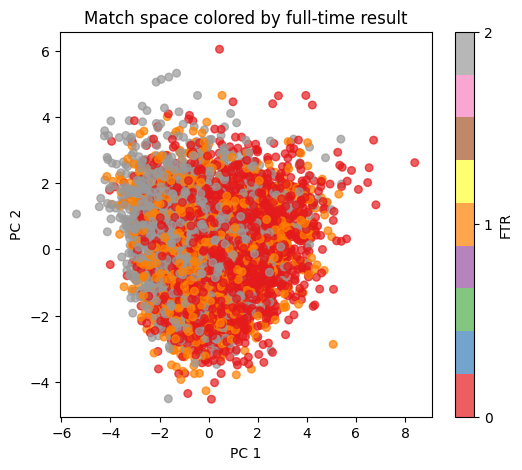

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


ftr_map = {"H": 0, "D": 1, "A": 2}
colors = df.loc[X.index, "FTR"].map(ftr_map)

plt.figure(figsize=(6,5))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=colors,
    cmap="Set1",
    s=30,
    alpha=0.7
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Match space colored by full-time result")
plt.colorbar(ticks=[0,1,2], label="FTR")
plt.show()

Chattens læsning:
The colors are heavily overlapping --> That tells you something fundamental:

There is no clean linear or low-dimensional separation between H / D / A outcomes based only on match statistics --> This is not a failure. It’s a truth about football.

Interpretation:
	•	Similar match styles can end differently
	•	Randomness, timing, penalties, red cards, finishing quality matter
	•	Match process ≠ match outcome

Rougly maps to:
            Chaotic
               ↑
   Away dom  ←   →  Home dom
               ↓
              Calm

Problemet er at finde optimal epsilon.

Bruge heuristic method til at finde epsilon:
minpts = 2 x d - 1 = 2 x 12 - 1 = 23


In [20]:
# -----------------------------
# 1) Extract raw columns
# -----------------------------
cols = ["HST", "AST", "HF", "AF"]
X_raw = df[cols].apply(pd.to_numeric, errors="coerce").dropna()

# -----------------------------
# 2) 2D difference features
# -----------------------------
X_2d = pd.DataFrame({
    "sot_diff":  X_raw["HST"] - X_raw["AST"],   # attacking dominance
    "foul_diff": X_raw["HF"]  - X_raw["AF"],    # physical imbalance
}, index=X_raw.index)

X_2d.head()

X_scaled = StandardScaler().fit_transform(X_2d)

db = DBSCAN(
    eps=0.6,        # smaller because only 2D
    min_samples=5
)

labels = db.fit_predict(X_scaled)

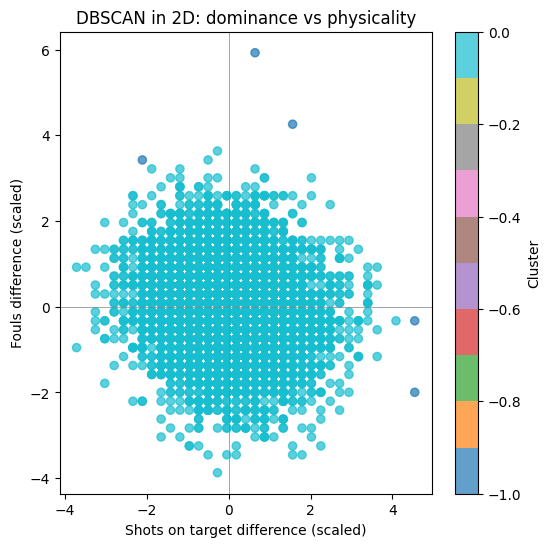

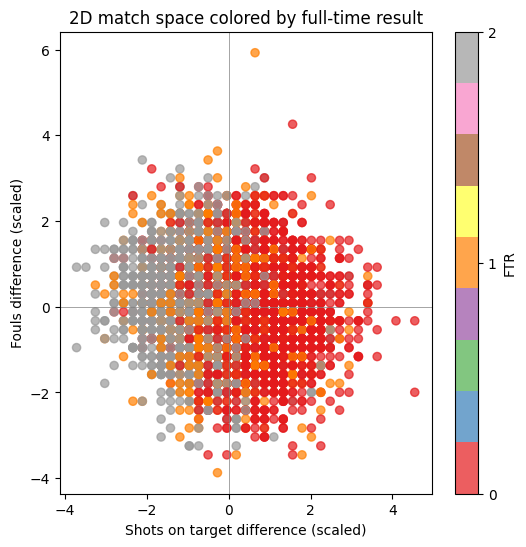


Cluster summary:
    size  percentage
-1  4485       54.73
 0  3686       44.98
 2     6        0.07
 1     5        0.06
 4     5        0.06
 3     4        0.05
 5     4        0.05
Total matches in plot: 8195
Unique (x,y) positions: 635


In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=labels,
    cmap="tab10",
    s=35,
    alpha=0.7
)
plt.axhline(0, color="gray", lw=0.5)
plt.axvline(0, color="gray", lw=0.5)

plt.xlabel("Shots on target difference (scaled)")
plt.ylabel("Fouls difference (scaled)")
plt.title("DBSCAN in 2D: dominance vs physicality")
plt.colorbar(label="Cluster")
plt.show()
ftr_map = {"H": 0, "D": 1, "A": 2}
colors = df.loc[X_2d.index, "FTR"].map(ftr_map)

plt.figure(figsize=(6,6))
plt.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=colors,
    cmap="Set1",
    s=35,
    alpha=0.7
)
plt.axhline(0, color="gray", lw=0.5)
plt.axvline(0, color="gray", lw=0.5)

plt.xlabel("Shots on target difference (scaled)")
plt.ylabel("Fouls difference (scaled)")
plt.title("2D match space colored by full-time result")
plt.colorbar(ticks=[0,1,2], label="FTR")
plt.show()

summary = pd.DataFrame({
    "size": pd.Series(clusters).value_counts(),
})

summary["percentage"] = summary["size"] / summary["size"].sum() * 100

print("\nCluster summary:")
print(summary.round(2))
print("Total matches in plot:", len(X_2d))
print("Unique (x,y) positions:", X_2d.drop_duplicates().shape[0])

In [22]:
for eps in [0.3, 0.4, 0.5, 0.6, 0.7]:
    labels = DBSCAN(eps=eps, min_samples=5).fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise = np.mean(labels == -1)
    print(f"eps={eps:.1f}: clusters={n_clusters}, noise={noise:.2f}")

eps=0.3: clusters=5, noise=0.01
eps=0.4: clusters=1, noise=0.00
eps=0.5: clusters=1, noise=0.00
eps=0.6: clusters=1, noise=0.00
eps=0.7: clusters=1, noise=0.00


In [24]:
from sklearn.cluster import DBSCAN
import numpy as np

eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [4, 5, 6, 8, 10]

print("DBSCAN parameter sweep (2D):")
print("eps  minPts  clusters  noise")

for min_pts in min_samples_values:
    for eps in eps_values:
        labels = DBSCAN(eps=eps, min_samples=min_pts).fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_frac = np.mean(labels == -1)
        
        print(f"{eps:3.1f}   {min_pts:6d}     {n_clusters:3d}     {noise_frac:5.2f}")
    print("-" * 40)

DBSCAN parameter sweep (2D):
eps  minPts  clusters  noise
0.3        4       4      0.01
0.4        4       2      0.00
0.5        4       1      0.00
0.6        4       1      0.00
0.7        4       1      0.00
----------------------------------------
0.3        5       5      0.01
0.4        5       1      0.00
0.5        5       1      0.00
0.6        5       1      0.00
0.7        5       1      0.00
----------------------------------------
0.3        6       2      0.01
0.4        6       2      0.01
0.5        6       1      0.00
0.6        6       1      0.00
0.7        6       1      0.00
----------------------------------------
0.3        8       1      0.02
0.4        8       3      0.01
0.5        8       1      0.00
0.6        8       1      0.00
0.7        8       1      0.00
----------------------------------------
0.3       10       1      0.02
0.4       10       1      0.01
0.5       10       1      0.00
0.6       10       1      0.00
0.7       10       1      0.00
---